In [ ]:
%cd /content
!rm -f tianchi
!git clone https://github.com/Dreaming-future/tianchi.git
%cd tianchi/CharacterCodingRecognition/
!pip install -r requirements.txt
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
%cd dataset/

/content
Cloning into 'tianchi'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 30 (delta 6), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (30/30), done.
/content/tianchi/CharacterCodingRecognition
     |████████████████████████████████| 804.1 MB 2.8 kB/s 
     |████████████████████████████████| 17.4 MB 595 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

# 赛题数据及理解
赛题以街道字符为为赛题数据，数据集报名后可见并可下载，该数据来自收集的SVHN街道字符，并进行了匿名采样处理。  



![数据示例](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/%E8%B5%9B%E4%BA%8B%E7%AE%80%E4%BB%8B/%E6%95%B0%E6%8D%AE%E9%9B%86%E6%A0%B7%E6%9C%AC%E5%B1%95%E7%A4%BA.png)
             
注意: 按照比赛规则，所有的参赛选手只能使用比赛给定的数据集完成训练，不能使用SVHN原始数据集进行训练。比赛结束后将会对Top选手进行代码审核，违规的选手将清除排行榜成绩。
         
训练集数据包括3W张照片，验证集数据包括1W张照片，每张照片包括颜色图像和对应的编码类别和具体位置；为了保证比赛的公平性，测试集A包括4W张照片，测试集B包括4W张照片。
       
需要注意的是本赛题需要选手识别图片中所有的字符，为了降低比赛难度，我们提供了训练集、验证集中所有字符的位置框。


    
## 数据标签      
对于训练数据每张图片将给出对于的编码标签，和具体的字符框的位置（训练集、验证集都给出字符位置），可用于模型训练：

 Field  | Description|
--------- | --------|
top	| 左上角坐标X |
height	| 字符高度 |
left   | 左上角最表Y |
width  | 字符宽度 |
label  | 字符编码 |
      
字符的坐标具体如下所示：     
![坐标](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/%E5%AD%97%E7%AC%A6%E5%9D%90%E6%A0%87.png)     
     
 在比赛数据（训练集和验证集）中，同一张图片中可能包括一个或者多个字符，因此在比赛数据的JSON标注中，会有两个字符的边框信息： 

 |原始图片|图片JSON标注|
 |----|-----|
 |![19](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/%E5%8E%9F%E5%A7%8B%E5%9B%BE%E7%89%87.png)    | ![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/%E5%8E%9F%E5%A7%8B%E5%9B%BE%E7%89%87%E6%A0%87%E6%B3%A8.png)  |
 

## 评测指标     
 选手提交结果与实际图片的编码进行对比，以编码整体识别准确率为评价指标。任何一个字符错误都为错误，最终评测指标结果越大越好，具体计算公式如下：     
                                              Score=编码识别正确的数量/测试集图片数量      

## 解题思路
赛题思路分析：赛题本质是分类问题，需要对图片的字符进行识别。但赛题给定的数据图片中不同图片中包含的字符数量不等，如下图所示。有的图片的字符个数为2，有的图片字符个数为3，有的图片字符个数为4。      
       
  |字符属性|图片|
 |----|-----|
 |字符：42   字符个数：2    | ![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/42.png)  |
 |字符：241   字符个数：3    | ![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/2411.png)  |
 |字符：7358   字符个数：4    | ![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/7358.png)  |
  
因此本次赛题的难点是需要对不定长的字符进行识别，与传统的图像分类任务有所不同。为了降低参赛难度，我们提供了一些解题思路供大家参考：     
      
- 简单入门思路：定长字符识别    
     
可以将赛题抽象为一个定长字符识别问题，在赛题数据集中大部分图像中字符个数为2-4个，最多的字符    个数为6个。                 
因此可以对于所有的图像都抽象为6个字符的识别问题，字符23填充为23XXXX，字符231填充为231XXX。      
![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/23xxxxxx.png)   

经过填充之后，原始的赛题可以简化了6个字符的分类问题。在每个字符的分类中会进行11个类别的分类，假如分类为填充字符，则表明该字符为空。         
- 专业字符识别思路：不定长字符识别 
        
![标注](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/%E4%B8%8D%E5%AE%9A%E9%95%BF%E5%AD%97%E7%AC%A6%E8%AF%86%E5%88%AB.png)      
            
在字符识别研究中，有特定的方法来解决此种不定长的字符识别问题，比较典型的有CRNN字符识别模型。     
在本次赛题中给定的图像数据都比较规整，可以视为一个单词或者一个句子。   

- 专业分类思路：检测再识别     
      
在赛题数据中已经给出了训练集、验证集中所有图片中字符的位置，因此可以首先将字符的位置进行识别，利用物体检测的思路完成。        
      
![IMG](https://github.com/datawhalechina/team-learning-cv/raw/master/CharacterCodingRecognition/IMG/Task01/%E6%A3%80%E6%B5%8B.png)           
            
此种思路需要参赛选手构建字符检测模型，对测试集中的字符进行识别。选手可以参考物体检测模型SSD或者YOLO来完成。

## 小结
综上所示，本次赛题虽然是一个简单的字符识别问题，但有多种解法可以使用到计算机视觉领域中的各个模型，是非常适合大家入门学习的。
三种解决思路的难度从低到高，因此建议入门学习的同学可以先学习定长字符识别的思路。在文档之后的内容中我们也会以定长字符识别为例，让大家逐渐入门计算机视觉。

# 下载数据集
根据提供csv中的链接，分别下载各个数据集，并且放在dataset文件夹中

In [ ]:
import pandas as pd
path = 'mchar_data_list_0515.csv'
download = pd.read_csv(path)
download

,file,size,link
0,mchar_train.zip,345.91MB,http://tianchi-competition.oss-cn-hangzhou.ali...
1,mchar_train.json,3.16MB,http://tianchi-competition.oss-cn-hangzhou.ali...
2,mchar_val.zip,200.16MB,http://tianchi-competition.oss-cn-hangzhou.ali...
3,mchar_val.json,1.03MB,http://tianchi-competition.oss-cn-hangzhou.ali...
4,mchar_test_a.zip,370.6MB,http://tianchi-competition.oss-cn-hangzhou.ali...
5,mchar_sample_submit_A.csv,507.83KB,http://tianchi-competition.oss-cn-hangzhou.ali...


In [ ]:
for link in download['link']:
        cmd = '!wget %s'%link
        print(cmd)

!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.zip
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.zip
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_test_a.zip
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_sample_submit_A.csv


In [ ]:
# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.zip
# !unzip -q mchar_train.zip

# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.zip
# !unzip -q mchar_val.zip

# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_sample_submit_A.csv
# !wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_test_a.zip
# !unzip -q mchar_test_a.zip
!sh get_train.sh # 得到训练文件并解压，包括训练集和验证集
!sh get_test.sh # 得到测试文件，并且解压，包括测试集图片和提交模板

--2022-03-27 03:10:44--  http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_train.json
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3310747 (3.2M) [application/json]
Saving to: ‘mchar_train.json’

mchar_train.json    100%[===================>]   3.16M  1.52MB/s    in 2.1s    

2022-03-27 03:10:47 (1.52 MB/s) - ‘mchar_train.json’ saved [3310747/3310747]

--2022-03-27 03:10:47--  http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531795/mchar_val.json
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.c

## JSON 数据读取方式

[[ 77  81]
 [219 219]
 [246 323]
 [ 81  96]
 [  1   9]]


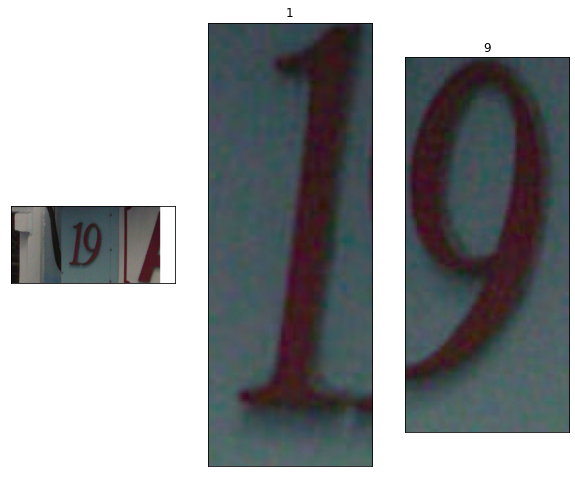

In [ ]:
import matplotlib.pyplot as plt
import json,cv2
import numpy as np

train_json = json.load(open('./mchar_train.json'))

# 数据标注处理
def parse_json(d):
   arr = np.array([
       d['top'], d['height'], d['left'],  d['width'], d['label']
   ])
   arr = arr.astype(int)
   return arr

img = cv2.imread('./mchar_train/000000.png')
arr = parse_json(train_json['000000.png'])
print(arr)

plt.figure(figsize=(10, 10))
plt.subplot(1, arr.shape[1]+1, 1)
plt.imshow(img)
plt.xticks([]); plt.yticks([])

for idx in range(arr.shape[1]):
   plt.subplot(1, arr.shape[1]+1, idx+2)
   plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]])
   plt.title(arr[4, idx])
   plt.xticks([]); plt.yticks([])

# 数据读取

## 首先导入必要的库

In [ ]:
import os, sys, glob, shutil, json
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm, tqdm_notebook

%pylab inline

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

Populating the interactive namespace from numpy and matplotlib


In [ ]:
torch.__version__

'1.9.0+cu111'

In [ ]:
import random
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True # #for accelerating the running
setup_seed(0)


## 定义读取数据集

In [ ]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 4位字符的定长识别
        lbl = np.array(self.img_label[index], dtype=np.int32)
        lbl = list(lbl)  + (4 - len(lbl)) * [10]
        return img, torch.from_numpy(np.array(lbl[:4]))

    def __len__(self):
        return len(self.img_path)

## 定义读取数据dataloader

假设数据存放在`./dataset`文件夹下，并进行解压。

In [ ]:
train_path = glob.glob(r'./mchar_train/*.png')
train_path.sort()
train_json = json.load(open('./mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]
print(len(train_path), len(train_label))

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
                transforms.Compose([
                    transforms.Resize((64, 128)),
                    transforms.RandomCrop((60, 120)),
                    transforms.ColorJitter(0.3, 0.3, 0.2),
                    transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=True, 
    num_workers=0,
)

val_path = glob.glob('./mchar_val/*.png')
val_path.sort()
val_json = json.load(open('./mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]
print(len(val_path), len(val_label))

val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=0,
)

30000 30000
10000 10000


# 可视化数据

In [ ]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

In [ ]:
def imshow(img):
    for i in range(3):
      img[i,:,:] = img[i,:,:] * stds[i] + means[i]
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

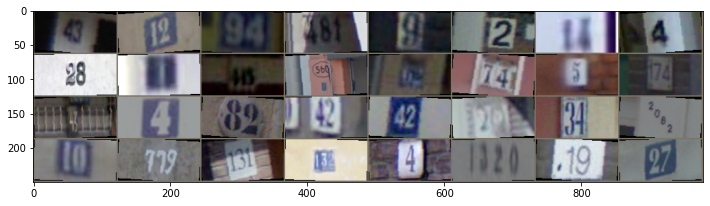

In [ ]:
import torchvision
im,label = next(iter(train_loader))
plt.figure(figsize=(12,16))
imshow(torchvision.utils.make_grid(im[:32]))

# 定义分类模型

这里使用ResNet50的模型进行特征提取

In [ ]:
class SVHN_Model2(nn.Module):
    def __init__(self):
        super(SVHN_Model2, self).__init__()
                
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        

    
    def forward(self, img):        
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
       
        # 分为4块进行识别，每一部分识别一个字符
        return c1, c2, c3, c4

# 定义训练函数

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []
    print('Start Train')
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
    with tqdm(total=len(train_loader),desc=f'Epoch {epoch + 1}/{epochs}',postfix=dict,mininterval=0.3,ncols=100) as pbar:    
        for i, (input, target) in enumerate(train_loader):
            if use_cuda:
                input = input.cuda()
                target = target.cuda()
            target = target.to(torch.long)
            c0, c1, c2, c3 = model(input)
            
            loss = criterion(c0, target[:, 0]) + \
                    criterion(c1, target[:, 1]) + \
                    criterion(c2, target[:, 2]) + \
                    criterion(c3, target[:, 3])
            
            # loss /= 6
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            lr = optimizer.param_groups[0]['lr']

            train_loss.append(loss.item())
            pbar.set_postfix(**{'Train Loss' : loss.item(),
                      'Lr': lr})
            pbar.update(1)
    scheduler.step(np.mean(train_loss))
    print('Finish Train')
    return np.mean(train_loss)



# 定义预测函数

In [ ]:
def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    print('Start Validation')
    with tqdm(total=len(val_loader),desc=f'Epoch {epoch + 1}/{epochs}',postfix=dict,mininterval=0.3,ncols=100) as pbar:    
    # 不记录模型梯度信息
        with torch.no_grad():
            for i, (input, target) in enumerate(val_loader):
                if use_cuda:
                    input = input.cuda()
                    target = target.cuda()
                target = target.to(torch.long)
                c0, c1, c2, c3 = model(input)
                loss = criterion(c0, target[:, 0]) + \
                        criterion(c1, target[:, 1]) + \
                        criterion(c2, target[:, 2]) + \
                        criterion(c3, target[:, 3])
                # loss /= 6
                pbar.set_postfix(**{'Val Loss' : loss.item()})
                pbar.update(1)
                val_loss.append(loss.item())
    print('Finish Validation')
    return np.mean(val_loss)

def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    
    # TTA 次数
    for _ in range(tta):
        test_pred = []
    
        with torch.no_grad():
            for i, (input, target) in enumerate(test_loader):
                if use_cuda:
                    input = input.cuda()
                
                c0, c1, c2, c3 = model(input)
                if use_cuda:
                    output = np.concatenate([
                        c0.data.cpu().numpy(), 
                        c1.data.cpu().numpy(),
                        c2.data.cpu().numpy(), 
                        c3.data.cpu().numpy()], axis=1)
                else:
                    output = np.concatenate([
                        c0.data.numpy(), 
                        c1.data.numpy(),
                        c2.data.numpy(), 
                        c3.data.numpy()], axis=1)
                
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

# 训练与验证

In [ ]:
model = SVHN_Model2()
criterion = nn.CrossEntropyLoss()
# 测试过后发现，如果学习率过大，我们的损失一开始会比较大，不一定是好的
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0

use_cuda = True
if use_cuda:
    model = model.cuda()

epochs = 20
for epoch in range(epochs):
    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
    val_predict_label = predict(val_loader, model, 1)
    val_predict_label = np.vstack([
        val_predict_label[:, :11].argmax(1),
        val_predict_label[:, 11:22].argmax(1),
        val_predict_label[:, 22:33].argmax(1),
        val_predict_label[:, 33:44].argmax(1),
    ]).T
    val_label_pred = []
    for x in val_predict_label:
        val_label_pred.append(''.join(map(str, x[x!=10])))
    
    val_char_acc = np.mean(np.array(val_label_pred) == np.array(val_label))
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}, Val Acc：{3}'.format(epoch+1, train_loss, val_loss, val_char_acc))
    # print('Val Acc', val_char_acc)
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        # print('Find better model in Epoch {0}, saving model.'.format(epoch))
        torch.save(model.state_dict(), './model.pt')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Start Train


Epoch 1/20:   0%|                                             | 0/750 [00:00<?, ?it/s<class 'dict'>]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 1/20: 100%|██████████████████████| 750/750 [01:43<00:00,  7.25it/s, Lr=0.001, Train Loss=1.84]


Finish Train
Start Validation


Epoch 1/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.44it/s, Val Loss=3.41]


Finish Validation
Epoch: 1, Train loss: 3.4011955965360006 	 Val loss: 3.427509938240051, Val Acc：0.3516
Start Train


Epoch 2/20: 100%|██████████████████████| 750/750 [01:26<00:00,  8.69it/s, Lr=0.001, Train Loss=2.79]


Finish Train
Start Validation


Epoch 2/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.60it/s, Val Loss=3.35]


Finish Validation
Epoch: 2, Train loss: 2.1627918586730956 	 Val loss: 3.05732191324234, Val Acc：0.4268
Start Train


Epoch 3/20: 100%|██████████████████████| 750/750 [01:26<00:00,  8.71it/s, Lr=0.001, Train Loss=1.72]


Finish Train
Start Validation


Epoch 3/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.78it/s, Val Loss=2.56]


Finish Validation
Epoch: 3, Train loss: 1.8142305934429168 	 Val loss: 2.8796279106140137, Val Acc：0.4481
Start Train


Epoch 4/20: 100%|██████████████████████| 750/750 [01:25<00:00,  8.76it/s, Lr=0.001, Train Loss=1.33]


Finish Train
Start Validation


Epoch 4/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.42it/s, Val Loss=2.39]


Finish Validation
Epoch: 4, Train loss: 1.6212913997968037 	 Val loss: 2.55434611082077, Val Acc：0.5169
Start Train


Epoch 5/20: 100%|█████████████████████| 750/750 [01:25<00:00,  8.73it/s, Lr=0.001, Train Loss=0.647]


Finish Train
Start Validation


Epoch 5/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.67it/s, Val Loss=2.46]


Finish Validation
Epoch: 5, Train loss: 1.46302103861173 	 Val loss: 2.710729061603546, Val Acc：0.5034
Start Train


Epoch 6/20: 100%|██████████████████████| 750/750 [01:25<00:00,  8.74it/s, Lr=0.001, Train Loss=1.02]


Finish Train
Start Validation


Epoch 6/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.68it/s, Val Loss=2.46]


Finish Validation
Epoch: 6, Train loss: 1.3458783167203268 	 Val loss: 2.535611736059189, Val Acc：0.5346
Start Train


Epoch 7/20: 100%|█████████████████████| 750/750 [01:25<00:00,  8.77it/s, Lr=0.001, Train Loss=0.894]


Finish Train
Start Validation


Epoch 7/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.77it/s, Val Loss=2.31]


Finish Validation
Epoch: 7, Train loss: 1.252318230509758 	 Val loss: 2.558355032444, Val Acc：0.5323
Start Train


Epoch 8/20: 100%|██████████████████████| 750/750 [01:25<00:00,  8.81it/s, Lr=0.001, Train Loss=1.82]


Finish Train
Start Validation


Epoch 8/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.79it/s, Val Loss=2.53]


Finish Validation
Epoch: 8, Train loss: 1.1579245049158733 	 Val loss: 2.5115495290756225, Val Acc：0.539
Start Train


Epoch 9/20: 100%|██████████████████████| 750/750 [01:25<00:00,  8.80it/s, Lr=0.001, Train Loss=2.27]


Finish Train
Start Validation


Epoch 9/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.77it/s, Val Loss=2.72]


Finish Validation
Epoch: 9, Train loss: 1.078088370680809 	 Val loss: 2.79056142950058, Val Acc：0.5119
Start Train


Epoch 10/20: 100%|████████████████████| 750/750 [01:25<00:00,  8.81it/s, Lr=0.001, Train Loss=0.855]


Finish Train
Start Validation


Epoch 10/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.82it/s, Val Loss=2.33]


Finish Validation
Epoch: 10, Train loss: 1.0271357669830323 	 Val loss: 2.397695080280304, Val Acc：0.564
Start Train


Epoch 11/20: 100%|█████████████████████| 750/750 [01:25<00:00,  8.82it/s, Lr=0.001, Train Loss=1.19]


Finish Train
Start Validation


Epoch 11/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.84it/s, Val Loss=2.11]


Finish Validation
Epoch: 11, Train loss: 0.9512184093395869 	 Val loss: 2.4905688486099242, Val Acc：0.5494
Start Train


Epoch 12/20: 100%|████████████████████| 750/750 [01:26<00:00,  8.66it/s, Lr=0.001, Train Loss=0.593]


Finish Train
Start Validation


Epoch 12/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.53it/s, Val Loss=2.22]


Finish Validation
Epoch: 12, Train loss: 0.9087337478995323 	 Val loss: 2.5220902276039125, Val Acc：0.5585
Start Train


Epoch 13/20: 100%|████████████████████| 750/750 [01:27<00:00,  8.58it/s, Lr=0.001, Train Loss=0.679]


Finish Train
Start Validation


Epoch 13/20: 100%|█████████████████████████████████| 250/250 [00:19<00:00, 12.69it/s, Val Loss=1.85]


Finish Validation
Epoch: 13, Train loss: 0.853402161081632 	 Val loss: 2.530381724834442, Val Acc：0.5613
Start Train


Epoch 14/20: 100%|████████████████████| 750/750 [01:28<00:00,  8.43it/s, Lr=0.001, Train Loss=0.584]


Finish Train
Start Validation


Epoch 14/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.29it/s, Val Loss=2.26]


Finish Validation
Epoch: 14, Train loss: 0.8023295370737712 	 Val loss: 2.640278242111206, Val Acc：0.5529
Start Train


Epoch 15/20: 100%|████████████████████| 750/750 [01:25<00:00,  8.74it/s, Lr=0.001, Train Loss=0.929]


Finish Train
Start Validation


Epoch 15/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.71it/s, Val Loss=2.18]


Finish Validation
Epoch: 15, Train loss: 0.7299676354527473 	 Val loss: 2.5660257229804992, Val Acc：0.5647
Start Train


Epoch 16/20: 100%|█████████████████████| 750/750 [01:26<00:00,  8.67it/s, Lr=0.001, Train Loss=1.21]


Finish Train
Start Validation


Epoch 16/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.59it/s, Val Loss=2.62]


Finish Validation
Epoch: 16, Train loss: 0.6963981216549874 	 Val loss: 2.780525733947754, Val Acc：0.5404
Start Train


Epoch 17/20: 100%|█████████████████████| 750/750 [01:26<00:00,  8.65it/s, Lr=0.001, Train Loss=0.89]


Finish Train
Start Validation


Epoch 17/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.56it/s, Val Loss=2.63]


Finish Validation
Epoch: 17, Train loss: 0.6410515947043895 	 Val loss: 2.7812403366565706, Val Acc：0.5435
Start Train


Epoch 18/20: 100%|████████████████████| 750/750 [01:26<00:00,  8.67it/s, Lr=0.001, Train Loss=0.778]


Finish Train
Start Validation


Epoch 18/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.53it/s, Val Loss=2.07]


Finish Validation
Epoch: 18, Train loss: 0.5971450991034508 	 Val loss: 2.9123527455329894, Val Acc：0.5482
Start Train


Epoch 19/20: 100%|████████████████████| 750/750 [01:26<00:00,  8.66it/s, Lr=0.001, Train Loss=0.803]


Finish Train
Start Validation


Epoch 19/20: 100%|█████████████████████████████████| 250/250 [00:18<00:00, 13.54it/s, Val Loss=2.63]


Finish Validation
Epoch: 19, Train loss: 0.5646312094430129 	 Val loss: 2.9886586046218873, Val Acc：0.5546
Start Train


Epoch 20/20: 100%|████████████████████| 750/750 [01:26<00:00,  8.63it/s, Lr=0.001, Train Loss=0.579]


Finish Train
Start Validation


Epoch 20/20: 100%|██████████████████████████████████| 250/250 [00:18<00:00, 13.54it/s, Val Loss=2.2]


Finish Validation
Epoch: 20, Train loss: 0.5124713344772657 	 Val loss: 2.981527897834778, Val Acc：0.5634


In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(model,(1,3,60,120))

Layer (type:depth-idx)                        Output Shape              Param #
SVHN_Model2                                   --                        --
├─Sequential: 1-1                             [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [1, 64, 30, 60]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 30, 60]           128
│    └─ReLU: 2-3                              [1, 64, 30, 60]           --
│    └─MaxPool2d: 2-4                         [1, 64, 15, 30]           --
│    └─Sequential: 2-5                        [1, 64, 15, 30]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 15, 30]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 15, 30]           73,984
│    └─Sequential: 2-6                        [1, 128, 8, 15]           --
│    │    └─BasicBlock: 3-3                   [1, 128, 8, 15]           230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 8, 15]           295,42

# 预测并生成提交文件

In [ ]:
test_path = glob.glob('./mchar_test_a/*.png')
test_path.sort()
# test_json = json.load(open('./mchar_test_a.json'))
test_label = [[1]] * len(test_path)
print(len(test_path), len(test_label))

test_loader = torch.utils.data.DataLoader(
    SVHNDataset(test_path, test_label,
                transforms.Compose([
                    transforms.Resize((60, 120)),   # TODO: modify here
                    # transforms.RandomCrop((60, 120)),
                    # transforms.ColorJitter(0.3, 0.3, 0.2),
                    # transforms.RandomRotation(5),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])), 
    batch_size=40, 
    shuffle=False, 
    num_workers=0,
)

40000 40000


In [ ]:
# 加载保存的最优模型
model.load_state_dict(torch.load('model.pt'))

test_predict_label = predict(test_loader, model, 1)
print(test_predict_label.shape)

test_label = [''.join(map(str, x)) for x in test_loader.dataset.img_label]
test_predict_label = np.vstack([
    test_predict_label[:, :11].argmax(1),
    test_predict_label[:, 11:22].argmax(1),
    test_predict_label[:, 22:33].argmax(1),
    test_predict_label[:, 33:44].argmax(1),
]).T

test_label_pred = []
for x in test_predict_label:
    test_label_pred.append(''.join(map(str, x[x!=10])))
    

(40000, 44)


In [ ]:
import pandas as pd
df_submit = pd.read_csv('./mchar_sample_submit_A.csv')
df_submit['file_code'] = test_label_pred
df_submit.to_csv('submit.csv', index=None)

In [ ]:
from google.colab import files

files.download('submit.csv')
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>